In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

/usr/lib/python3/dist-packages/statsmodels/__init__.py:6: UserWarning: This appears to be an armel system, on which statsmodels is buggy (crashes and possibly wrong answers) - https://bugs.debian.org/968210
  warnings.warn("This appears to be an armel system, on which statsmodels is buggy (crashes and possibly wrong answers) - https://bugs.debian.org/968210")


   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   0.283391  -0.926267   0.557481   1.078631  -0.203070  -0.178120   
1   0.213756   0.287929   0.243148   1.318006  -0.433444  -0.062180   
2   0.666562  -0.137078   0.293372   0.872091   0.781729   0.159389   
3   0.578333   0.493204   0.701925   0.579410   0.056084  -0.592031   
4   0.427161  -0.464810  -0.376869  -0.642858  -0.558782   0.426227   

   Feature_6  Feature_7  Feature_8  Feature_9  Target  
0   0.381685  -0.473143   1.215612  -0.173695       1  
1  -0.117407  -0.227901   0.437375   0.354748       1  
2  -0.133566   0.042678   0.461084  -0.988073       1  
3  -0.178221  -0.457276   0.550565   0.912795       1  
4   0.990020   0.256532   0.015204   1.028715       0  


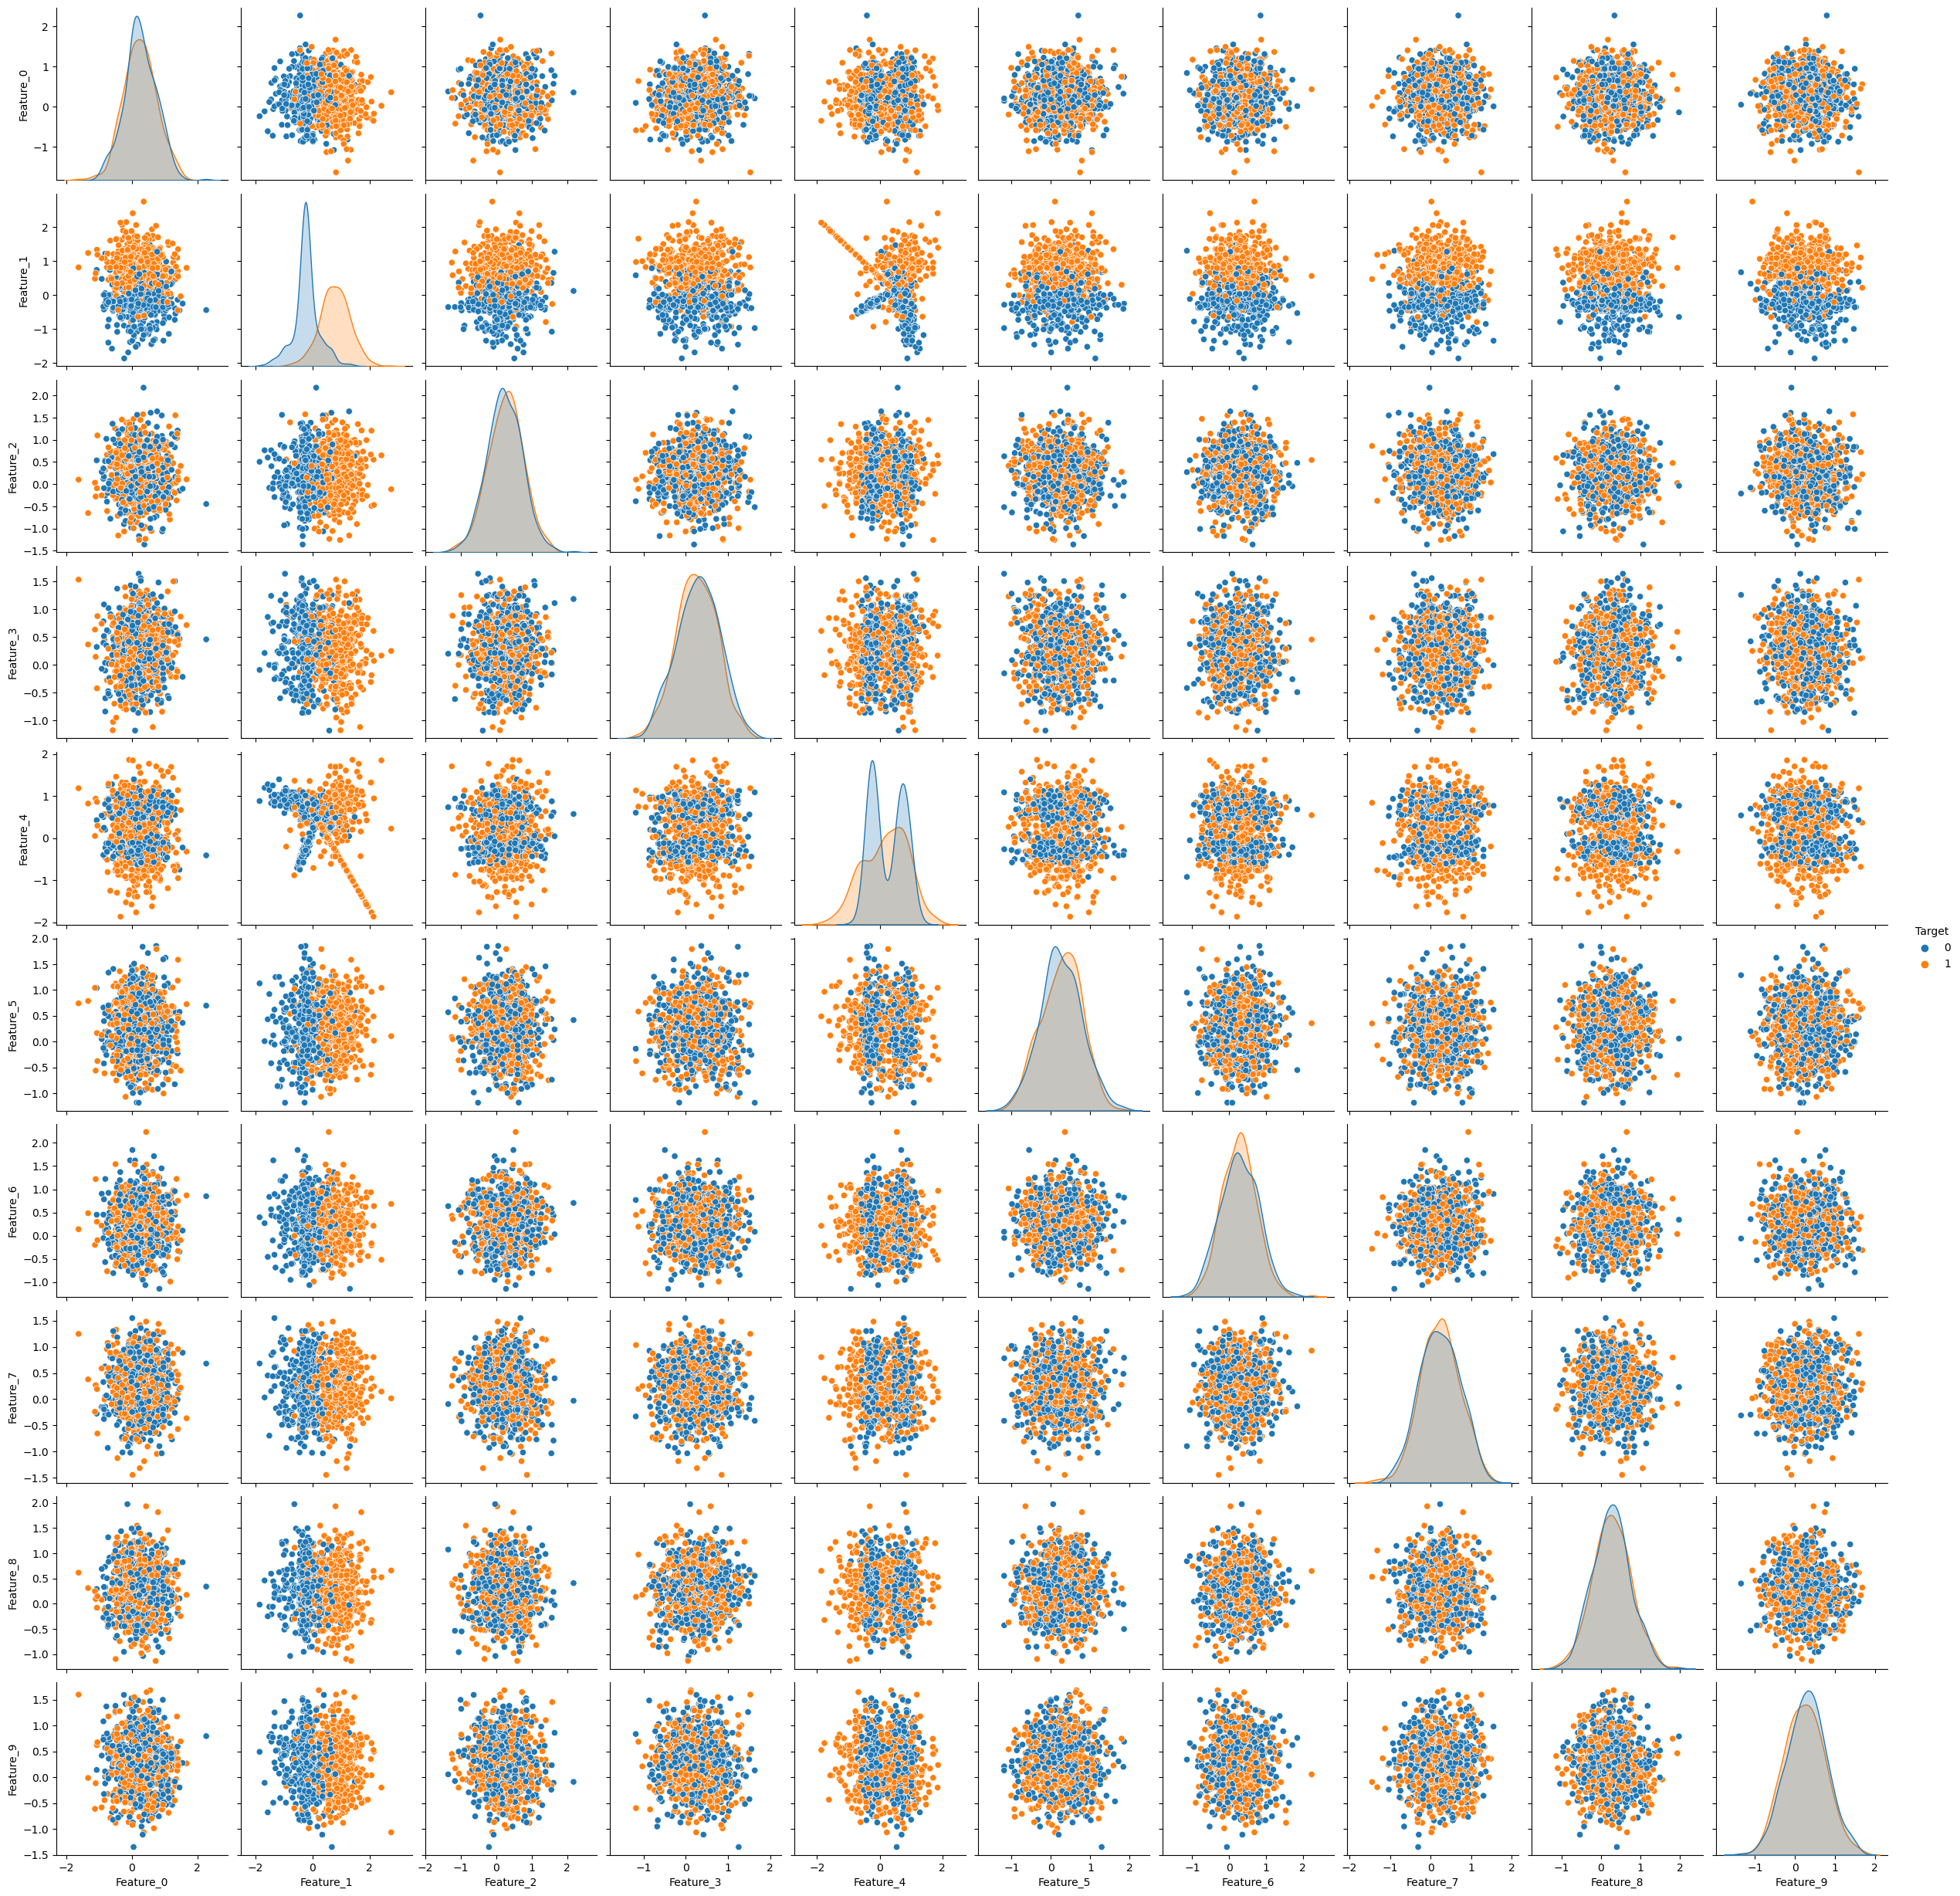

In [37]:
X, y = make_classification(
                    n_samples=1000,
                    n_features=10,
                    n_informative=2,
                    n_redundant=0,
                    n_classes=2,
                    n_clusters_per_class=2,
                    flip_y=0.01,
                    class_sep=1.0,
                    hypercube=True,
                    shift=0.5,       # moyenne de 0.5
                    scale=0.5,
                    shuffle=True,
                    random_state=None
                )

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X) # Tentative de normalisation des données

columns = [f'Feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=columns)
df['Target'] = y

print(df.head())

sns.pairplot(df, hue='Target', diag_kind='kde')
plt.show()

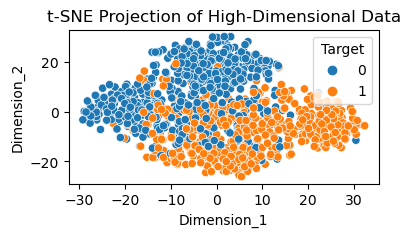

In [39]:
# perplexity [10, 30, 50]

# nb d'iterations : de base à 1000 mais je pense que c'est trop on peut réduire. En réalité il faut observe au bout 
# de combien d'iteration le resultat converge


# n_components[2, 5 ,10] attention à ne pas avoir un nombre de dimensions dans l'espace reduit superieur aux nombres
# de dimensions dans l'espace initial





tsne = TSNE(n_components=2,perplexity=40, random_state=300)

X_tsne = tsne.fit_transform(X)

df_tsne = pd.DataFrame(X_tsne, columns=['Dimension_1', 'Dimension_2'])
df_tsne['Target'] = y

plt.figure(figsize=(4, 2))
sns.scatterplot(x='Dimension_1', y='Dimension_2', hue='Target', data=df_tsne)
plt.title('t-SNE Projection of High-Dimensional Data')
plt.show()

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_tsne.values)




J'ai implémenté le calcul de la métrique ecart type des ratios de distance euclidienne dans l'espace initial et l'espace réduit

In [23]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def std_ratios(X_initial,X_reduced):

    distances_initial = euclidean_distances(X_initial)  #Je calcule la distance euclidienne entre chaque paire de points dans l'espace initial
    print(distances_initial)

    distances_reduced = euclidean_distances(X_reduced)  #Je calcule la distance euclidienne entre chaque paire de points dans l'espace réduit
    #print(distances_initial)

    ratio = distances_reduced / (distances_initial + 0.00000000001) # au cas ou il y a une valeur = 0 meme si je pense que c'est impossoble
    print(ratio)

    std_ratios = np.std(ratio)

    return std_ratios

print(std_ratios(X,X_tsne))




[[0.         1.02551973 1.40937417 ... 1.0769734  1.86025268 1.30479789]
 [1.02551973 0.         0.97860599 ... 1.35470558 1.74080799 1.53265269]
 [1.40937417 0.97860599 0.         ... 0.96833522 1.69156705 1.97088016]
 ...
 [1.0769734  1.35470558 0.96833522 ... 0.         1.41709096 1.50016697]
 [1.86025268 1.74080799 1.69156705 ... 1.41709096 0.         1.29378792]
 [1.30479789 1.53265269 1.97088016 ... 1.50016697 1.29378792 0.        ]]
[[ 0.          9.14350648 15.2038528  ... 12.97799146 25.37123661
  13.83549053]
 [ 9.14350648  0.         27.88867907 ... 14.90613212 23.16800436
  12.47549915]
 [15.2038528  27.88867907  0.         ...  7.70262943 39.95104553
  19.68956783]
 ...
 [12.97799146 14.90613212  7.70262943 ...  0.         42.57256504
  21.0261795 ]
 [25.37123661 23.16800436 39.95104553 ... 42.57256504  0.
  27.92681381]
 [13.83549053 12.47549915 19.68956783 ... 21.0261795  27.92681381
   0.        ]]
8.597326642744598


J'essaye d'implémenter knn. L'idée est en fait de comparer les voisins de chaque point dans l'espace initial et dans l'espace réduit pour voir à quel point tsne a conservé les voisins.

In [45]:
def average_common_neighbors(X_initial, X_reduced, k):
    # Je cherche les k plus proches voisins dans l'espace initial
    knn_initial = NearestNeighbors(n_neighbors=k)
    knn_initial.fit(X_initial)
    distances, indices_initial = knn_initial.kneighbors(X_initial)          #kneighbors renvoie les indices et les distances 
                                                                            #des voisins de chaque point.
    #print(indices_initial)
    #print(distances)
    
    # Je cherche les k plus proches voisins dans l'espace réduit
    knn_reduced = NearestNeighbors(n_neighbors=k)
    knn_reduced.fit(X_reduced)
    distances, indices_reduced = knn_reduced.kneighbors(X_reduced)
    #print(indices_reduced)
    
    # Je calcule le nombre moyen de voisins en commun
    common_neighbors = []

    for i in range(len(indices_initial)):
        neighbors_initial = set(indices_initial[i]) #j'utilise set parce qu'avec les listes c'etait long pour trouver les indices en commun. Set transforme la liste
        neighbors_reduced = set(indices_reduced[i])  # en un ensemble de données
        common_neighbors.append(len(neighbors_initial.intersection(neighbors_reduced)))
    
    
    print(len(neighbors_reduced))
    
    avg_common_neighbors = np.mean(common_neighbors)

    return avg_common_neighbors

# Utilisation de la fonction
avg_common_neighbors10 = average_common_neighbors(X, X_tsne, k=10)
avg_common_neighbors40 = average_common_neighbors(X, X_tsne, k=40)
print("Le nombre moyen de voisins en commun en utilisant k=10 voisins est" ,avg_common_neighbors10)
print("Le nombre moyen de voisins en commun en utilisant k=40 voisins est" ,avg_common_neighbors40)



10
40
Le nombre moyen de voisins en commun en utilisant k=10 voisins est 4.509
Le nombre moyen de voisins en commun en utilisant k=40 voisins est 14.196


L'idée pour la troisième metrics est de comparer les distances entre les points interclusters pour savoir si les clusters sont respectés dans l'espace réduit. On appelle cela le Silouhette score.